# Machine learning supervisé  : la régression linéaire

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Rappel sur la régression linéaire

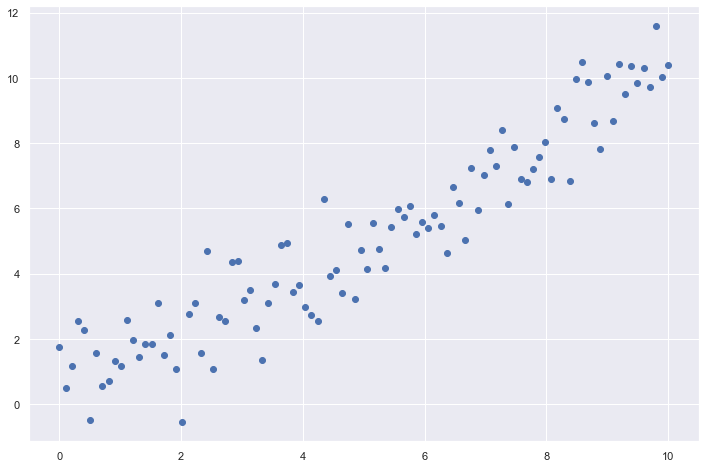

In [347]:
from sklearn.linear_model import LinearRegression

np.random.seed(0)
m = 100 # creation de 100 échantillons
X = np.linspace(0, 10, m).reshape(m,1)
y = X + np.random.randn(m, 1)

plt.figure(figsize=(12,8))
plt.scatter(X, y)
plt.show()

In [346]:
model = LinearRegression() #on parle d'estimateur et on précise alors ses hyperparamètres
model.fit(X, y) # entrainement du modele
model.score(X, y) # évaluation avec le coefficient de corrélation

0.25845207303751283

In [342]:
predictions=model.predict(X)


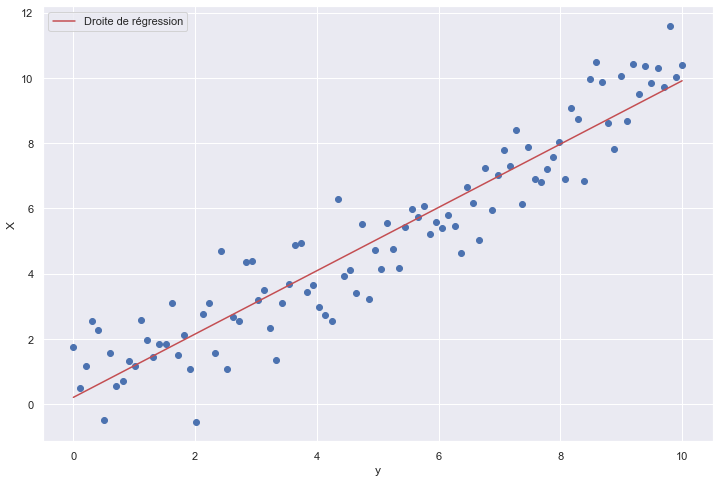

In [344]:
plt.figure(figsize=(12,8))
plt.scatter(X, y)
plt.plot(X,predictions,c='r',label='Droite de régression')
plt.ylabel('X')
plt.xlabel('y')
plt.legend()
plt.show()

# Régression Ridge

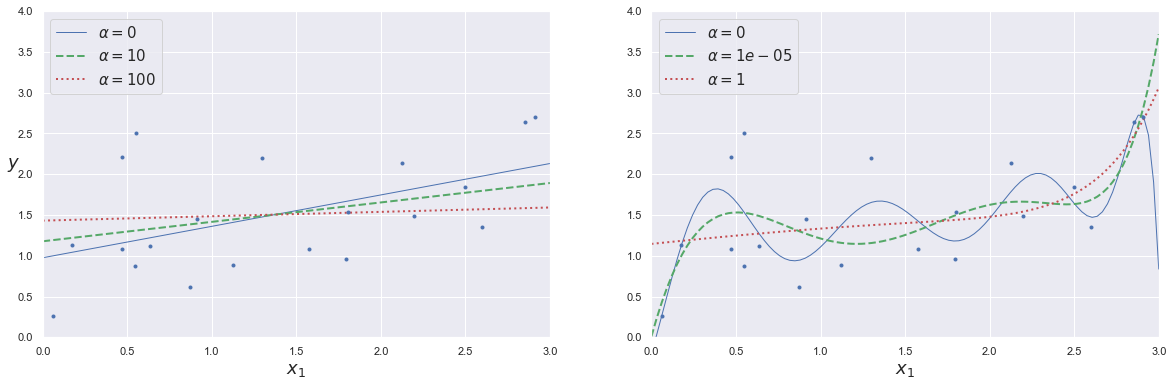

In [351]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(20,6))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

In [4]:
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

# Régression Lasso

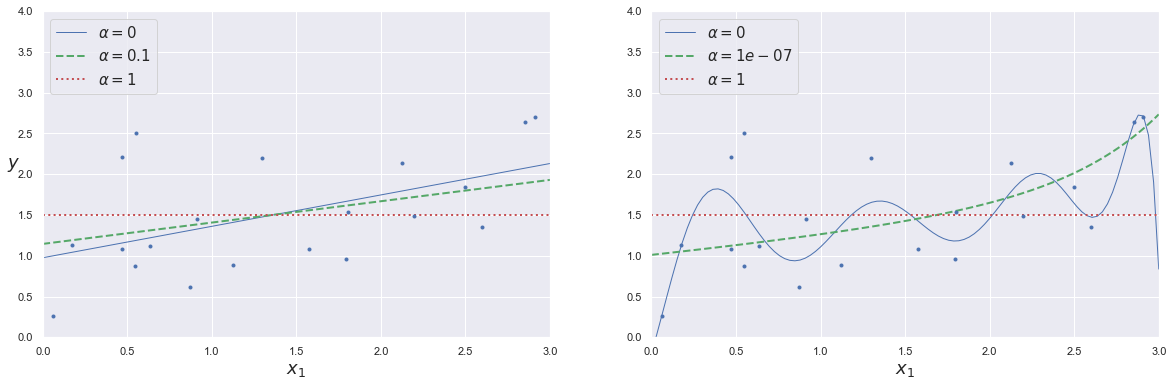

In [353]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(20,6))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

plt.show()

In [6]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

# Régression Elastic Net

In [7]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

# Early stopping

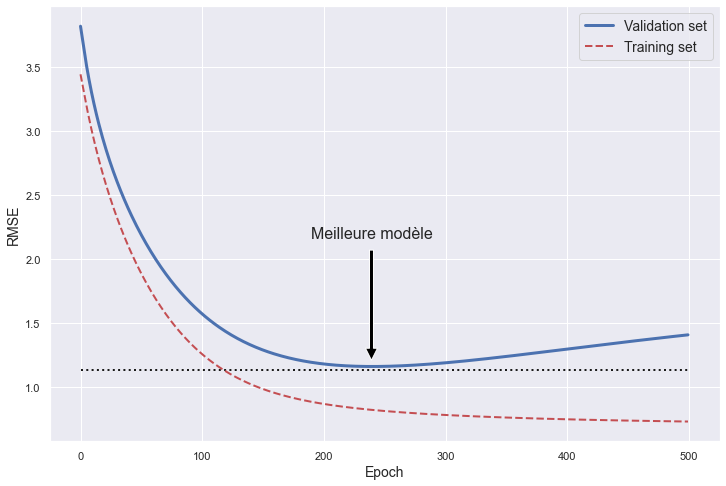

In [357]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.figure(figsize=(12,8))
plt.annotate('Meilleure modèle',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better


plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

plt.show()

# Un exemple concret : housing.data

A. Titre : Données sur le logement à Boston

B. Sources :
   (a) Origine :  Cet ensemble de données a été extrait de la bibliothèque StatLib qui est
                maintenue à l'université Carnegie Mellon.
   (b) Créateur :  Harrison, D. et Rubinfeld, D.L. "Hedonic prices and the 
                 demande d'air pur", J. Environ. Economics & Management,
                 vol.5, 81-102, 1978.
   (c) Date : 7 juillet 1993


C. Informations pertinentes : ces données concernent la valeur des logements dans les banlieues de Boston.

D. Nombre d'instances : 506

E. Nombre d'attributs : 13 attributs continus (dont la classe d'attribut "MEDV"), 1 attribut à valeur binaire (CHAS)

F. Informations sur l'attribut :

    1. CRIM : taux de criminalité par quartier
    2. ZN : proportion de terrains résidentiels pour les lots de plus de 2000 mètres carrés
    3. INDUS : proportion d'hectares d'activités non commerciales
    4. CHAS : logement au bord du fleuve "Charles River" (= 1 si oui ; = 0 sinon)
    5. NOX : concentration en oxydes d'azote  (parties pour 10 millions)
    6. RM : nombre moyen de pièces par logement
    7. AGE : proportion de logements construits avant 1940 occupés par leurs propriétaires 
    8. DIS : distances pondérées par rapport à cinq centres Pôle Emploi de Boston
    9. RAD : Indice d'accessibilité aux autoroutes radiales
    10. TAXE : taux de la taxe foncière
    11. PTRATIO : rapport élèves/enseignant par quartier
    12. B : =1000(Bk - 0,63)^2 où Bk est la proportion de noirs par quartier
    13. LSTAT :  strate de la population (en %)
    14. MEDV : valeur médiane des logements occupés par leurs propriétaires en milliers de dollars

G. Valeurs d'attributs manquantes :  Aucune.

In [3]:
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.data"
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
dataframe = pd.read_csv(url, delim_whitespace=True, names=names)
array = dataframe.values


In [4]:
dataframe.shape


(506, 14)

NameError: name 'plt' is not defined

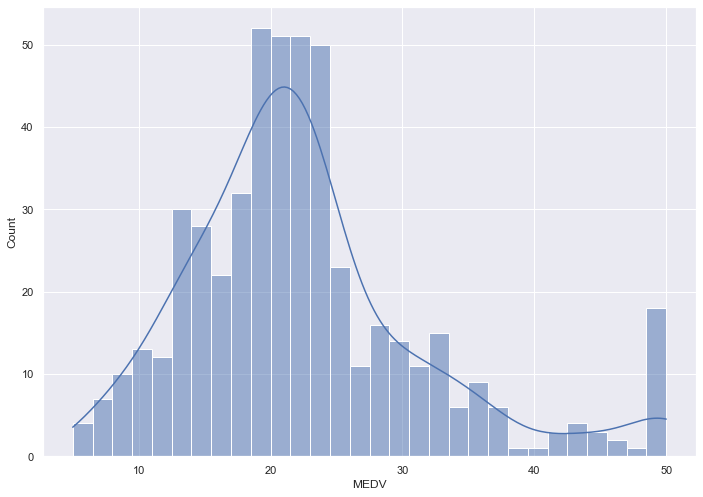

In [5]:
#une belle distribution normale avec quelques outliers
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(x=dataframe['MEDV'], bins=30,stat='count',kde=True)
plt.show()

<AxesSubplot:>

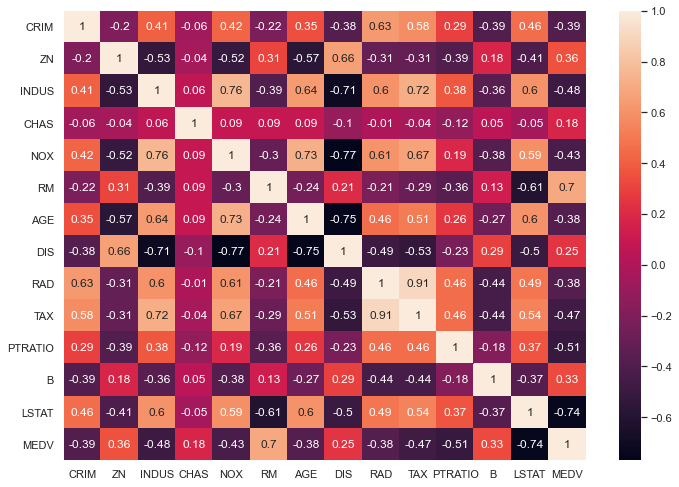

In [6]:
correlation_matrix = dataframe.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

on observe une bonne corrélation entre la cible de la régression 'MEDV' et RM et LSTAT. En revanche avec les autres variables, pas vraiment. 

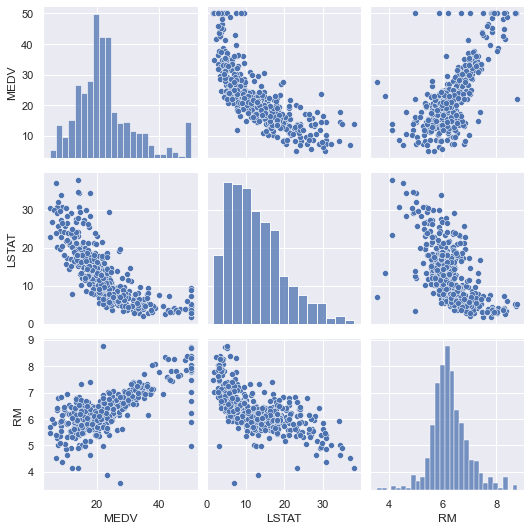

In [7]:
sns.set(rc={'figure.figsize':(15,15)})
sns.pairplot(data=dataframe,x_vars=['MEDV','LSTAT','RM'],y_vars=['MEDV','LSTAT','RM'],
             corner=False,diag_kind="hist",kind="scatter")


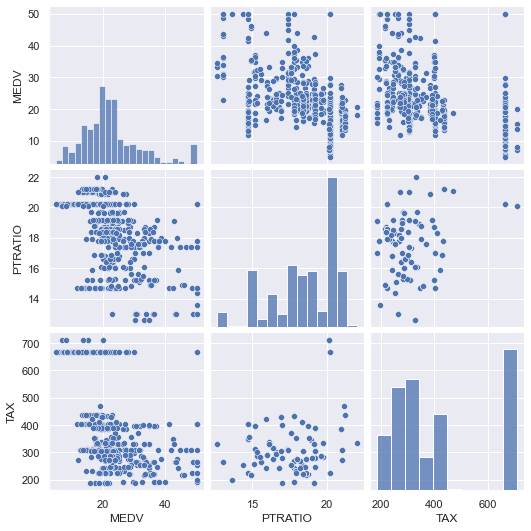

In [8]:
sns.set(rc={'figure.figsize':(15,15)})
sns.pairplot(data=dataframe,x_vars=['MEDV','PTRATIO','TAX'],y_vars=['MEDV','PTRATIO','TAX'],
             corner=False,diag_kind="hist",kind="scatter")

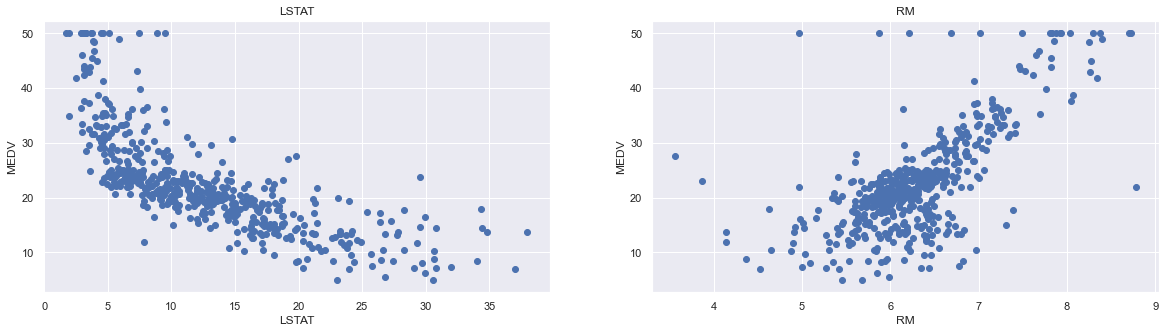

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = dataframe['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = dataframe[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

In [17]:
dataframe.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [18]:
#le dataframe, le germe de l'aléa et le découpage pour la cross-validation
X = array[:,0:13]
Y = array[:,13]
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed,shuffle=True)

## Par régression linéaire simple

In [21]:
from sklearn.linear_model import LinearRegression
# Linear Regression
model_LR1 = LinearRegression()
model_LR2 = LinearRegression()
scoring_MSE = 'neg_mean_squared_error'
scoring_MAE= 'neg_mean_absolute_error'
results = model_selection.cross_val_score(model_LR1, X, Y, cv=kfold, scoring=scoring_MSE)
print(results.mean())

-23.74650181131342


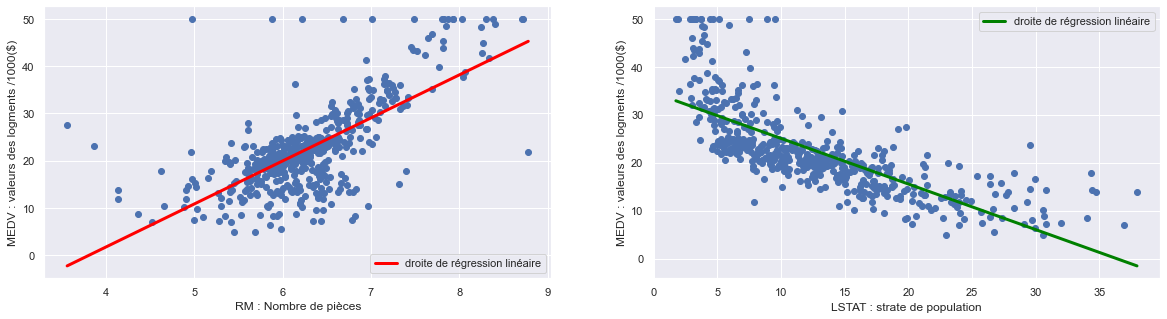

In [22]:
X_rooms = dataframe['RM']
X_strate=dataframe['LSTAT']
y_price = dataframe['MEDV']

X_rooms = np.array(X_rooms).reshape(-1,1)
X_strate= np.array(X_strate).reshape(-1,1)
y_price = np.array(y_price).reshape(-1,1)

model_LR1.fit(X_rooms,y_price)
model_LR2.fit(X_strate,y_price)

prediction_space1 = np.linspace(min(X_rooms), max(X_rooms)).reshape(-1,1) 
prediction_space2 = np.linspace(min(X_strate), max(X_strate)).reshape(-1,1) 

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.scatter(X_rooms,y_price)
plt.plot(prediction_space1, model_LR1.predict(prediction_space1), color = 'red', 
         linewidth = 3,label='droite de régression linéaire')
plt.ylabel('MEDV : valeurs des logments /1000($)')
plt.xlabel('RM : Nombre de pièces')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X_strate,y_price)
plt.plot(prediction_space2, model_LR2.predict(prediction_space2), color = 'green', 
         linewidth = 3,label='droite de régression linéaire')
plt.ylabel('MEDV : valeurs des logments /1000($)')
plt.xlabel('LSTAT : strate de population')
plt.legend()

plt.show()

# SGD Regressor, la régression linéaire par la descente de gradient

In [23]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

model_SGD1 = make_pipeline(StandardScaler(),SGDRegressor(random_state=0))

model_SGD1.fit(X, Y)


scoring = 'neg_mean_squared_error'
results = model_selection.cross_val_score(model_SGD1, X, Y, cv=kfold,scoring=scoring)
print(results.mean())

-23.813171992615743


In [24]:
#Hyperparamètres pour tuner SGDRegressor
hyperparams={
    'sgdregressor__alpha':[0.1,0.01,0.001,0.0001,0.00001],
    'sgdregressor__learning_rate':['constant','optimal','invscaling','adaptive'],
    'sgdregressor__max_iter':[100,300,600,1000,1200,1500,2000],
    'sgdregressor__penalty':['l2','l1','elasticnet']
    }


model_SGD2=make_pipeline(StandardScaler(),SGDRegressor(random_state=0))

In [25]:
grille_de_recherche = GridSearchCV(model_SGD2, param_grid=hyperparams, scoring=scoring, cv=kfold, n_jobs=-1)

In [26]:
# perform the search
resultats = grille_de_recherche.fit(X, Y)
# summarize
print('MAE: %.3f' % resultats.best_score_)
print('Config: %s' % resultats.best_params_)

MAE: -23.700
Config: {'sgdregressor__alpha': 0.01, 'sgdregressor__learning_rate': 'adaptive', 'sgdregressor__max_iter': 100, 'sgdregressor__penalty': 'l2'}


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


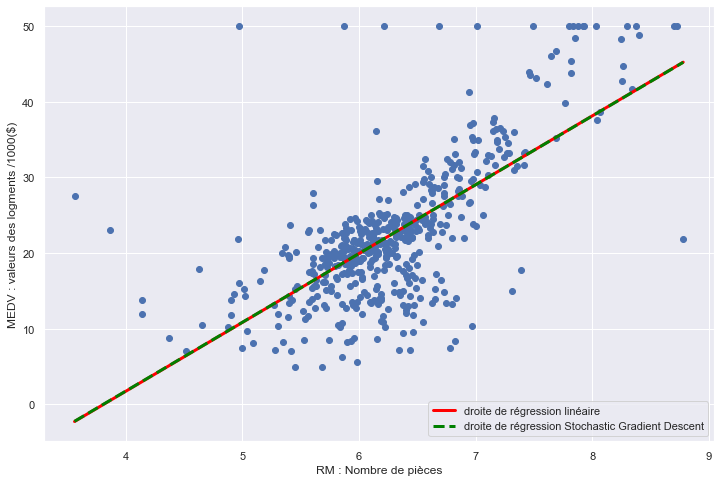

In [27]:
X_rooms = dataframe['RM']
y_price = dataframe['MEDV']
X_rooms = np.array(X_rooms).reshape(-1,1)
y_price = np.array(y_price).reshape(-1,1)
model_SGD2.fit(X_rooms,y_price)
prediction_space = np.linspace(min(X_rooms), max(X_rooms)).reshape(-1,1) 

plt.figure(figsize=(12,8))
plt.scatter(X_rooms,y_price)
plt.plot(prediction_space, model_LR1.predict(prediction_space), color = 'red', 
         linewidth = 3,label='droite de régression linéaire')
plt.plot(prediction_space, model_SGD2.predict(prediction_space), color = 'green',ls='--',
         linewidth = 3,label='droite de régression Stochastic Gradient Descent')
plt.ylabel('MEDV : valeurs des logments /1000($)')
plt.xlabel('RM : Nombre de pièces')
plt.legend()
plt.show()

## Par Ridge

In [28]:
# Ridge Regression
from sklearn.linear_model import Ridge
model_Ridge = Ridge(alpha=1.0)
scoring = 'neg_mean_squared_error'
results = model_selection.cross_val_score(model_Ridge, X, Y, cv=kfold, scoring=scoring)
print(results.mean())

-23.88989018505344


In [29]:
#recherche du meilleur hyperparamètre alpha par gridsearch

from sklearn.model_selection import GridSearchCV
#définir plusieurs valeurs de l'hyperparamètre alpha
grille={'alpha':[0.01,0.1,1,10,100]}
grille2={'alpha':np.arange(0, 1, 0.01)}

# definir la grille de recherche 
grille_de_recherche = GridSearchCV(model_Ridge, grille2, scoring=scoring_MAE, cv=kfold, n_jobs=-1)

# perform the search
resultats = grille_de_recherche.fit(X, Y)
# summarize
print('MAE: %.3f' % resultats.best_score_)
print('Config: %s' % resultats.best_params_)


MAE: -3.376
Config: {'alpha': 0.46}


In [30]:
#dans Scikit Learn, il existe une bibliothèque qui fait cela directement
from sklearn.linear_model import RidgeCV
model_RidgeCV = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=kfold, scoring=scoring_MAE)
# fit model
model_RidgeCV.fit(X, Y)
# summarize chosen configuration
print('alpha: %f' % model_RidgeCV.alpha_)

alpha: 0.460000


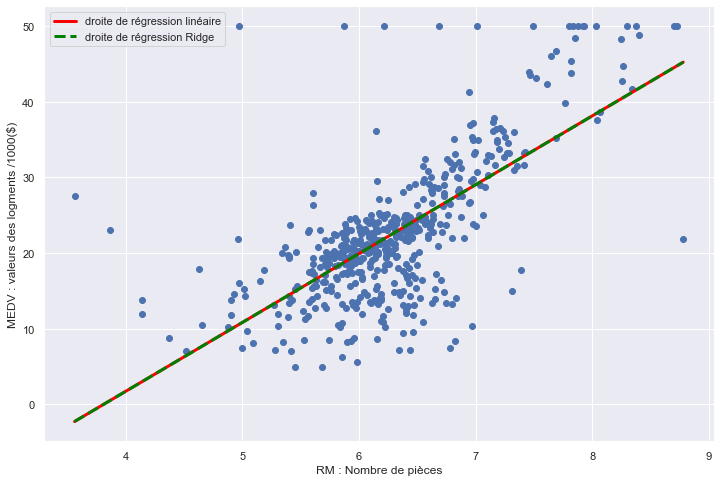

In [31]:
X_rooms = dataframe['RM']
y_price = dataframe['MEDV']
X_rooms = np.array(X_rooms).reshape(-1,1)
y_price = np.array(y_price).reshape(-1,1)
model_RidgeCV.fit(X_rooms,y_price)
prediction_space = np.linspace(min(X_rooms), max(X_rooms)).reshape(-1,1) 

plt.figure(figsize=(12,8))
plt.scatter(X_rooms,y_price)
plt.plot(prediction_space, model_LR1.predict(prediction_space), color = 'red', 
         linewidth = 3,label='droite de régression linéaire')
plt.plot(prediction_space, model_RidgeCV.predict(prediction_space), color = 'green',ls='--',
         linewidth = 3,label='droite de régression Ridge')
plt.ylabel('MEDV : valeurs des logments /1000($)')
plt.xlabel('RM : Nombre de pièces')
plt.legend()
plt.show()

## Par Lasso

In [32]:
# Lasso Regression
from sklearn.linear_model import Lasso
model_Lasso = Lasso()
scoring = 'neg_mean_squared_error'
results = model_selection.cross_val_score(model_Lasso, X, Y, cv=kfold, scoring=scoring)
print(results.mean())

-28.745890075851538


In [33]:
#recherche du meilleur hyperparamètre alpha par gridsearch

from sklearn.model_selection import GridSearchCV
#définir plusieurs valeurs de l'hyperparamètre alpha
grille={'alpha':[0.01,0.1,1,10,100]}
grille2={'alpha':np.arange(0, 1, 0.01)}

# definir la grille de recherche 
grille_de_recherche = GridSearchCV(model_Lasso, grille, scoring=scoring_MAE, cv=kfold, n_jobs=-1)

# perform the search
resultats = grille_de_recherche.fit(X, Y)
# summarize
print('MAE: %.3f' % resultats.best_score_)
print('Config: %s' % resultats.best_params_)


MAE: -3.378
Config: {'alpha': 0.01}


In [34]:
#dans Scikit Learn, il existe une bibliothèque qui fait cela directement
from sklearn.linear_model import LassoCV
model_LassoCV = LassoCV(alphas=np.arange(0.01, 1, 0.01), cv=kfold)
# fit model
model_LassoCV.fit(X, Y)
# summarize chosen configuration
print('alpha: %f' % model_LassoCV.alpha_)

alpha: 0.010000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


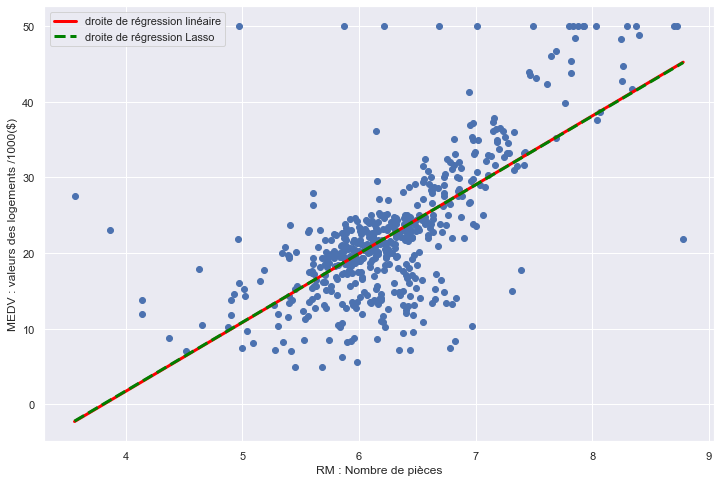

In [35]:
X_rooms = dataframe['RM']
y_price = dataframe['MEDV']
X_rooms = np.array(X_rooms).reshape(-1,1)
y_price = np.array(y_price).reshape(-1,1)
model_LassoCV.fit(X_rooms,y_price)
prediction_space = np.linspace(min(X_rooms), max(X_rooms)).reshape(-1,1) 


plt.figure(figsize=(12,8))
plt.scatter(X_rooms,y_price)
plt.plot(prediction_space, model_LR1.predict(prediction_space), color = 'red', 
         linewidth = 3,label='droite de régression linéaire')
plt.plot(prediction_space, model_LassoCV.predict(prediction_space), color = 'green',ls='--',
         linewidth = 3,label='droite de régression Lasso')
plt.ylabel('MEDV : valeurs des logements /1000($)')
plt.xlabel('RM : Nombre de pièces')
plt.legend()
plt.show()

## Par Elastic Net

In [36]:
# ElasticNet Regression

from sklearn.linear_model import ElasticNet

model_Elastic = ElasticNet()
scoring = 'neg_mean_squared_error'
results = model_selection.cross_val_score(model_Elastic, X, Y, cv=kfold, scoring=scoring)
print(results.mean())

-27.90842036023106


In [37]:
# fit model
model_Elastic.fit(X, Y)
row = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
# make a prediction
yhat = model_Elastic.predict([row])
# summarize prediction
print('Predicted: %.3f' % yhat)

Predicted: 31.047


In [38]:
#recherche du meilleur hyperparamètre alpha par gridsearch

from sklearn.model_selection import GridSearchCV
#définir plusieurs valeurs de l'hyperparamètre alpha
grille={'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100],'l1_ratio':np.arange(0.01, 1, 0.01)}

# definir la grille de recherche 
grille_de_recherche = GridSearchCV(model_Elastic, grille, scoring=scoring_MAE, cv=kfold, n_jobs=-1)

# perform the search
resultats = grille_de_recherche.fit(X, Y)
# summarize
print('MAE: %.3f' % resultats.best_score_)
print('Config: %s' % resultats.best_params_)

MAE: -3.376
Config: {'alpha': 0.001, 'l1_ratio': 0.01}


In [39]:
from sklearn.linear_model import ElasticNetCV
ratios = np.arange(0.01, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
model_ECV = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=kfold, n_jobs=-1)
# fit model
model_ECV.fit(X, Y)

ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
             cv=KFold(n_splits=10, random_state=7, shuffle=True),
             l1_ratio=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
             n_jobs=-1)

In [40]:
print('alpha: %f' % model_ECV.alpha_)
print('l1_ratio_: %f' % model_ECV.l1_ratio_)

alpha: 0.000100
l1_ratio_: 0.010000


In [41]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

L'explication ci-dessus montre les caractéristiques qui contribuent chacune à faire passer la sortie du modèle de la valeur de base (la sortie moyenne du modèle sur l'ensemble des données de formation que nous avons passées) à la sortie du modèle. Les caractéristiques qui poussent la prédiction vers le haut sont indiquées en rouge, celles qui poussent la prédiction vers le bas sont en bleu.

Si nous prenons de nombreuses explications comme celle présentée ci-dessus, les faisons pivoter de 90 degrés, puis les empilons horizontalement, nous pouvons voir des explications pour tout un ensemble de données

In [42]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

Pour comprendre comment une caractéristique unique affecte la sortie du modèle, nous pouvons tracer la valeur SHAP de cette caractéristique par rapport à la valeur de la caractéristique pour tous les exemples d'un ensemble de données. Étant donné que les valeurs SHAP représentent la responsabilité d'une caractéristique pour un changement dans la sortie du modèle, le graphique ci-dessous représente le changement du prix prévu des maisons en fonction de l'évolution du RM (le nombre moyen de pièces par maison dans une zone). La dispersion verticale à une seule valeur de RM représente les effets d'interaction avec d'autres caractéristiques. Pour aider à révéler ces interactions, dependence_plot sélectionne automatiquement une autre caractéristique à colorier. Dans ce cas, la coloration par RAD (indice d'accessibilité aux autoroutes radiales) met en évidence que le nombre moyen de pièces par maison a moins d'impact sur le prix de la maison pour les zones ayant une valeur RAD élevée.



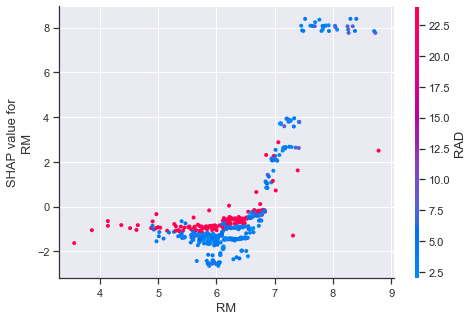

In [43]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("RM", shap_values, X)

Pour obtenir une vue d'ensemble des caractéristiques les plus importantes pour un modèle, nous pouvons tracer les valeurs SHAP de chaque caractéristique pour chaque échantillon. Le graphique ci-dessous trie les caractéristiques par la somme des valeurs SHAP sur tous les échantillons et utilise les valeurs SHAP pour montrer la distribution des impacts de chaque caractéristique sur la sortie du modèle. La couleur représente la valeur de l'élément (rouge haut, bleu bas). Cela révèle par exemple qu'un LSTAT élevé (% de statut inférieur de la population) fait baisser le prix prévu de la maison.

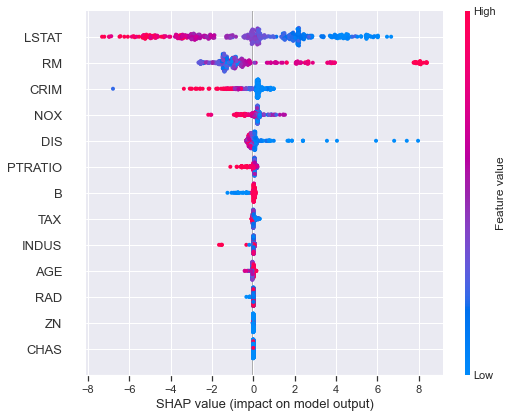

In [44]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

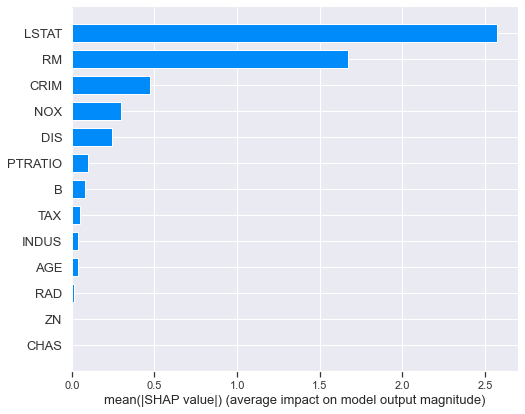

In [45]:
shap.summary_plot(shap_values, X, plot_type="bar")